In [ ]:
#Mounting on co-lab
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/My Drive/Interpretable_DNN') # change folder name

Mounted at /content/drive


In [ ]:
#Import of Libaries

import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy.ma.core import argmax

#Model Building and Explanations
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend, Model, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


#plots
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go



#custom functions
from functions.data_proc import *
from functions.experiment_setup import *
from functions.generate_inputs import *

### Experiment

In [ ]:
#Experimental parameters
prediction = 'Outcome' 
experiment =  'AG' #'AG_LS' #'AG','MS', 'IX'
timelapsed = 'total'
exp = 'EXP_2' #'EXP_0': old architecture, 'EXP_1': new architecture, 'EXP_2': Imbalanced test set

#Directories
MY_WORKSPACE_DIR = "/content/drive/My Drive/Interpretable_DNN/BPIC12_v2"
MILESTONE_DIR = "/content/drive/My Drive/Interpretable_DNN/BPIC12_v2/"+exp+'/'+experiment+'/'

log = 'BPIC_2012'

#Dataset
log_name = 'bpic_2012'


### Evaluation of Model Explanations

In [ ]:
#files

#model explanations
file_explanations = os.path.join(MILESTONE_DIR,log_name+'_'+experiment+'_explanations.csv')

#LR explanations
file_explanations_LR = os.path.join(MILESTONE_DIR,os.path.join('EVAL',log_name+'_'+experiment+'_LR_explanations.csv'))

#DL explanations
file_explanations_DL = os.path.join(MILESTONE_DIR,os.path.join('EVAL',log_name+'_'+experiment+'_DL_explanations.csv'))

#loading dataframes

#model explanations
df_explanations = pd.read_csv(file_explanations).reset_index(drop = True)
df_explanations = df_explanations.iloc[:,1:]

#LR explanations
df_explanations_LR = pd.read_csv(file_explanations_LR).reset_index(drop = True)
df_explanations_LR = df_explanations_LR.iloc[:,1:]


#converting the technical feature names into more user oriented feature names
feature_name_dict_ag = {'A_ACCEPTED_ag':'Occurence of A_ACCEPTED', 
                        'A_FINALIZED_ag':'Occurence of A_FINALIZED', 
                        'A_PARTLYSUBMITTED_ag' :'Occurence of A_PARTLYSUBMITTED',
                        'A_PREACCEPTED_ag' :'Occurence of A_PREACCEPTED', 
                        'A_SUBMITTED_ag':'Occurence of A_SUBMITTED', 
                        'W_COMPLETE_LEADS_ag': 'Occurence of W_COMPLETE_LEADS',
                        'W_COMPLETE_PREACCEPTED_APPLICATIONS_ag': 'Occurence of W_COMPLETE_PREACCEPTED',
                        'W_INVESTIGATING_FOR_FRAUD_ag': 'Occurence of W_INVESTIGATING_FOR_FRAUD', 
                        'O_CANCELLED_ag': 'Occurence of O_CANCELLED',
                        'O_SENT_ag': 'Occurence of O_SENT', 
                        'O_SENT_BACK_ag': 'Occurence of O_SENT_BACK', 
                        'W_ASSESSING_APPLICATION_ag': 'Occurence of W_ASSESSING_APPLICATION', 
                        'W_FOLLOWUP_MISSING_INFO_ag': 'Occurence of W_FOLLOWUP_MISSING_INFO', 
                        'W_FOLLOWUP_OFFER_ag': 'Occurence of W_FOLLOWUP_OFFER', 
                        'role_0_ag': 'Invovlement of role_0', 
                        'role_1_ag': 'Invovlement of role_1',
                        'role_2_ag': 'Invovlement of role_2', 
                        'role_3_ag': 'Invovlement of role_3', 
                        'role_4_ag': 'Invovlement of role_4', 
                        'amt': 'Loan amount requested',
                        't_ag':'Total_Duration',
                        't_dur_ag':'Average_Event_Duration'}

df_explanations['FEATURE_USER']=df_explanations['FEATURE'].replace(feature_name_dict_ag)
df_explanations_LR['FEATURE_USER']=df_explanations_LR['FEATURE'].replace(feature_name_dict_ag)
df_explanations = df_explanations[['CASEID','BUCKET','FEATURE','FEATURE_USER','FEATURE_VALUE','FEATURE_IMPORTANCE']]
df_explanations_LR = df_explanations_LR[['BUCKET','FEATURE','FEATURE_USER','FEATURE_WEIGHT']]

#DL explanations
df_explanations_DL = pd.read_csv(file_explanations_DL).reset_index(drop = True)
df_explanations_DL = df_explanations_DL.iloc[:,1:]

#converting the technical feature names into more explainable feature names in the event-level explanations
df_explanations_DL[['FEATURE_NAME','TIME_STEP']] = df_explanations_DL['FEATURE'].str.rsplit('_', 1,expand=True) #split the feature name and event index
df_explanations_DL[['MIN_LEN','MAX_LEN']] = df_explanations_DL['BUCKET'].str.rsplit('_', 1,expand=True)
df_explanations_DL['TIME_STEP_ASC'] = df_explanations_DL['MAX_LEN'].astype(int) -df_explanations_DL['TIME_STEP'].astype(int) #re-asign the event index from begining of the process = 1

feature_name_dict = {
    't':'Total_duration'
    ,'t_dur' : 'Event_duration'
}

df_explanations_DL['FEATURE_NAME_USER'] = df_explanations_DL['FEATURE_NAME'].replace(feature_name_dict)
df_explanations_DL['FEATURE_USER'] = df_explanations_DL['FEATURE_NAME_USER']+'_@event_'+df_explanations_DL['TIME_STEP_ASC'].astype(str)
df_explanations_DL = df_explanations_DL[['CASEID','BUCKET','FEATURE','FEATURE_USER','FEATURE_VALUE','FEATURE_IMPORTANCE']]


In [ ]:
#predictions

#model predictions
file_predictions = os.path.join(MILESTONE_DIR,log_name+'_'+experiment+'_predictions.csv')

#DL predictions
file_predictions_DL = os.path.join(MILESTONE_DIR,os.path.join('EVAL',log_name+'_'+experiment+'_DL_predictions.csv'))

#loading dataframes

#model predictions
df_predictions = pd.read_csv(file_predictions).reset_index(drop = True)
df_predictions = df_predictions.iloc[:,1:]


#DL predictions
df_predictions_DL = pd.read_csv(file_predictions_DL).reset_index(drop = True)
df_predictions_DL = df_predictions_DL.iloc[:,1:]



In [ ]:
df_explanations = df_explanations.merge(df_predictions, on = ['BUCKET','CASEID'])
df_explanations_DL = df_explanations_DL.merge(df_predictions_DL, on = ['BUCKET','CASEID'])
df_explanations.head()

CASEID BUCKET               FEATURE                    FEATURE_USER  \
0  173691    1_5         A_ACCEPTED_ag         Occurence of A_ACCEPTED   
1  173691    1_5        A_FINALIZED_ag        Occurence of A_FINALIZED   
2  173691    1_5  A_PARTLYSUBMITTED_ag  Occurence of A_PARTLYSUBMITTED   
3  173691    1_5      A_PREACCEPTED_ag      Occurence of A_PREACCEPTED   
4  173691    1_5        A_SUBMITTED_ag        Occurence of A_SUBMITTED   

   FEATURE_VALUE  FEATURE_IMPORTANCE  PREDICTION_PROB  PREDICTION GROUND_TRUTH  
0            1.0            0.006917         0.430823  A_APPROVED   A_APPROVED  
1            0.0            0.003725         0.430823  A_APPROVED   A_APPROVED  
2            1.0            0.007925         0.430823  A_APPROVED   A_APPROVED  
3            1.0            0.007769         0.430823  A_APPROVED   A_APPROVED  
4            1.0            0.007173         0.430823  A_APPROVED   A_APPROVED

#### Evaluation of Global Explanations - Prediction point 5

In [ ]:
#Choose the model with the best performance for model-x

best_model = '1_15'
color_a = '#1c2b42' #'#47a0b3' #,'#1c2b42'
local_case_level = df_explanations.loc[df_explanations['BUCKET'] == best_model]
global_case_level = df_explanations_LR.loc[df_explanations_LR['BUCKET'] == best_model]
local_event_level = df_explanations_DL.loc[df_explanations_DL['BUCKET'] == best_model]


Global Explanation of Logistic Regression

Text(0.5, 0.98, 'Global Explanation')

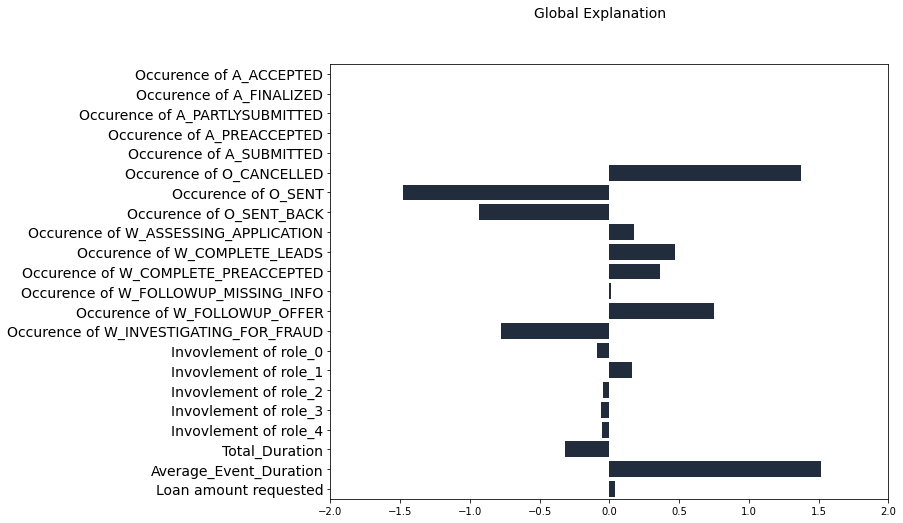

In [ ]:
fig, axes = plt.subplots(1,figsize=(10,8))
df_t = local_case_level.copy()
df_t2 = global_case_level.copy()

sn.barplot(data=df_t2 ,y='FEATURE_USER',x = 'FEATURE_WEIGHT', color = color_a, ax = axes)
axes.set_yticklabels(df_t2['FEATURE_USER'], rotation=0,fontsize=14)
axes.set(ylabel= None)
axes.set(xlabel= None)
axes.set_xlim([-2, 2])

fig.suptitle('Global Explanation',fontsize=14)

Text(0.5, 0.98, 'Global Explanation')

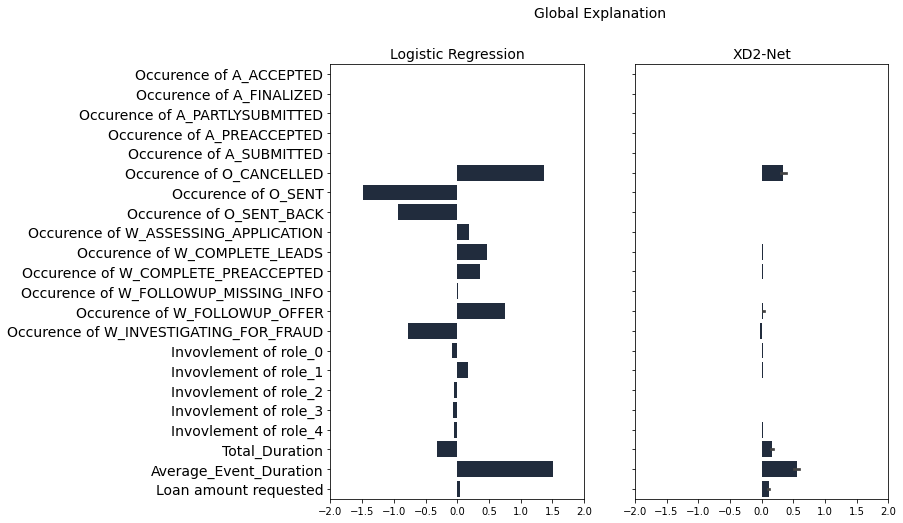

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,8))
df_t = local_case_level.copy()
df_t2 = global_case_level.copy()

sn.barplot(data=df_t2 ,y='FEATURE_USER',x = 'FEATURE_WEIGHT', color = color_a, ax = axes[0])
axes[0].set_yticklabels(df_t2['FEATURE_USER'], rotation=0,fontsize=14)
axes[0].set_title('Logistic Regression',fontsize=14)
axes[0].set(ylabel= None)
axes[0].set(xlabel= None)
axes[0].set_xlim([-2, 2])


sn.barplot(data=df_t ,y='FEATURE_USER',x = 'FEATURE_IMPORTANCE', color = color_a, ax = axes[1])
axes[1].set(yticklabels=[])
axes[1].set(ylabel= None)
axes[1].set(xlabel= None)
axes[1].set_title('XD2-Net',fontsize=14)
axes[1].set_xlim([-2, 2])

fig.suptitle('Global Explanation',fontsize=14)

#### Evaluation of Explanation Conciseness and Agreement

We evaluate the conciseness of explanation comparing the global explanation generated by Logistic regression and the globally aggregated explanation created by the XD2 net. We use three different aggregation mechanisms to aggregate the XD2 net explanation - Mean, Median and Maximum

In [ ]:
global_case_level_ag_mean = local_case_level.groupby(['BUCKET','FEATURE_USER'])['FEATURE_IMPORTANCE'].mean().reset_index()
global_case_level_ag_median = local_case_level.groupby(['BUCKET','FEATURE_USER'])['FEATURE_IMPORTANCE'].median().reset_index()
global_case_level_ag_max = local_case_level.groupby(['BUCKET','FEATURE_USER'])['FEATURE_IMPORTANCE'].max().reset_index()


#### Evaluation of Explanation Agreement

https://doi.org/10.48550/arXiv.2202.01602



We evaluate the feature agreement of the globally aggregated XD2 net explanation against the global explanation of Logistic Regression

In [ ]:
global_case_level['RANK'] = global_case_level['FEATURE_WEIGHT'].rank(method = 'dense', ascending = False)
global_case_level_ag_mean['RANK'] = global_case_level_ag_mean['FEATURE_IMPORTANCE'].rank(method = 'dense', ascending = False)
global_case_level_ag_median['RANK'] = global_case_level_ag_median['FEATURE_IMPORTANCE'].rank(method = 'dense', ascending = False)
global_case_level_ag_max['RANK'] = global_case_level_ag_max['FEATURE_IMPORTANCE'].rank(method = 'dense', ascending = False)

<ipython-input-52-f2c9d7c79630>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_case_level['RANK'] = global_case_level['FEATURE_WEIGHT'].rank(method = 'dense', ascending = False)


###### Feature Agreement

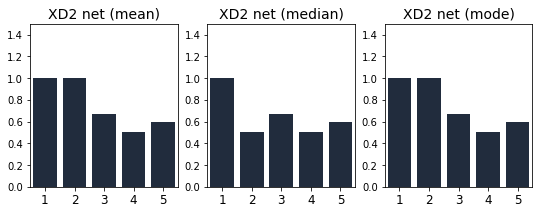

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(9,3))

for j, df in enumerate([global_case_level_ag_mean,global_case_level_ag_median,global_case_level_ag_max]): 

  titles = ['XD2 net (mean)','XD2 net (median)','XD2 net (mode)']
  feature_agreement = []
  top_k_features = list(range(1,6))
  for i in range(5):
    df_t = df.loc[df['RANK'] <=i+1]
    df_t2 = global_case_level.loc[global_case_level['RANK']<=i+1]
    df_t = df_t.merge(df_t2, on = 'FEATURE_USER')
    feature_agreement.append(len(df_t)/(i+1))

    #plot
  sn.barplot(y=feature_agreement ,x = top_k_features , color = color_a, ax = axes[j])
  axes[j].set_xticklabels(top_k_features, fontsize = 12)
  axes[j].set_title(titles[j],fontsize=14)
  axes[j].set_ylim([0, 1.5])




  


###### Rank Agreement

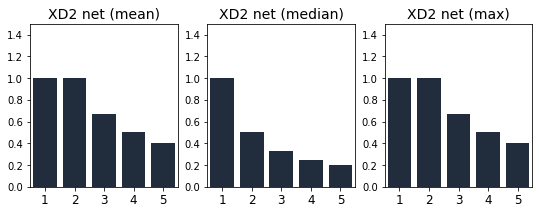

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(9,3))

for j, df in enumerate([global_case_level_ag_mean,global_case_level_ag_median,global_case_level_ag_max]): 

  titles = ['XD2 net (mean)','XD2 net (median)','XD2 net (max)']
  feature_agreement = []
  top_k_features = list(range(1,6))
  for i in range(5):
    df_t = df.loc[df['RANK'] <=i+1]
    df_t2 = global_case_level.loc[global_case_level['RANK']<=i+1]
    df_t = df_t.merge(df_t2, on = ['FEATURE_USER','RANK'])
    feature_agreement.append(len(df_t)/(i+1))

    #plot
  sn.barplot(y=feature_agreement ,x = top_k_features , color = color_a, ax = axes[j])
  axes[j].set_xticklabels(top_k_features, fontsize = 12)
  axes[j].set_title(titles[j],fontsize=14)
  axes[j].set_ylim([0, 1.5])

#### Explanation Conciseness

In [ ]:
global_case_level_ag_mean = local_case_level.groupby(['BUCKET','FEATURE_USER'])['FEATURE_IMPORTANCE'].mean().reset_index()
global_case_level_ag_median = local_case_level.groupby(['BUCKET','FEATURE_USER'])['FEATURE_IMPORTANCE'].median().reset_index()
global_case_level_ag_max = local_case_level.groupby(['BUCKET','FEATURE_USER'])['FEATURE_IMPORTANCE'].max().reset_index()

In [ ]:
#Ranking the features by the absolute value of the feature importance

global_case_level['RANK'] = abs(global_case_level['FEATURE_WEIGHT']).rank(method = 'dense', ascending = True)
global_case_level_ag_mean['RANK'] = abs(global_case_level_ag_mean['FEATURE_IMPORTANCE']).rank(method = 'dense', ascending = True)
global_case_level_ag_median['RANK'] = abs(global_case_level_ag_median['FEATURE_IMPORTANCE']).rank(method = 'dense', ascending = True)
global_case_level_ag_max['RANK'] = abs(global_case_level_ag_max['FEATURE_IMPORTANCE']).rank(method = 'dense', ascending = True)

<ipython-input-56-a03244eef898>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_case_level['RANK'] = abs(global_case_level['FEATURE_WEIGHT']).rank(method = 'dense', ascending = True)


In [ ]:
#get a dataframe only with feature values and case IDs
df_features = local_case_level[['CASEID','FEATURE_USER','FEATURE_VALUE','FEATURE_IMPORTANCE']]

#get a dataframe only with case ID and ground truth
df_cases = local_case_level[['CASEID','GROUND_TRUTH']].drop_duplicates()
outcome_dict = {'A_APPROVED':0, 'A_DECLINED':1}
df_cases['Y_TRUE'] = df_cases['GROUND_TRUTH'].map(outcome_dict)


In [ ]:
#get the model coefficients
model_XD_file =  os.path.join(MILESTONE_DIR,'_model_'+ best_model +'.pkl')
with open(model_XD_file, 'rb') as f:
    xd = pickle.load(f)
xd_c = xd.get_layer('act_output').get_weights()[1][0]


model_LR_file =  os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),'_LR_model_'+ best_model +'.pkl')
with open(model_LR_file, 'rb') as f:
    lr = pickle.load(f)
lr_c = lr.intercept_[0]

In [ ]:
from tensorflow.python.ops.math_ops import reciprocal_grad
from tensorflow.python.compiler.xla import jit
dfs = [global_case_level,global_case_level_ag_mean,global_case_level_ag_median,global_case_level_ag_max]
y_cols = ['Y_LR','Y_XD_mean','Y_XD_med','Y_XD_max']

tp_LR = []
tp_XD_mean = []
tp_XD_med = []
tp_XD_max = []
tp_arr = [tp_LR,tp_XD_mean,tp_XD_med,tp_XD_max]  

for j in range(4):
  if j ==0:

    df_exp = dfs[j]
    y_col = y_cols[j]

    for i in range(len(global_case_level)):

      df_cases_t = df_cases.copy()
  
      df_t = df_exp.loc[df_exp['RANK']>i][['FEATURE_USER','FEATURE_WEIGHT']]
      df_t = df_t.merge(df_features, on = 'FEATURE_USER')

      df_t['AGG'] = df_t['FEATURE_VALUE']*df_t['FEATURE_WEIGHT']
      df_t = df_t.groupby('CASEID')['AGG'].sum().reset_index()
      df_t[y_col] = 1 / (1 + np.exp(-(df_t['AGG']+lr_c)))

      if i == 0:
        df_all = df_t.copy().drop(columns = 'AGG')
        df_all.columns = ['CASEID',y_col+'_all']
    
      df_t = df_t.merge(df_all, on = 'CASEID')

      df_t['ERROR'] = df_t[y_col] - df_t[y_col+'_all']
      df_t['SQE'] = df_t['ERROR']**2
      rmse = (df_t['SQE'].mean())**0.5
      '''
      df_t = df_t.drop(columns = 'AGG')    
      df_cases_t = df_cases_t.merge(df_t, on = 'CASEID')

      df_tp = df_cases_t.loc[(df_cases_t['Y_TRUE'] == 1 )&(df_cases_t[y_col] == 1 )]
      tpr = len(df_tp)/(len(df_cases_t.loc[(df_cases_t['Y_TRUE'] == 1 )])+1)
      '''
      tp_arr[j].append(rmse)

  else:

    df_exp = dfs[j]
    y_col = y_cols[j]

    for i in range(len(global_case_level)):      
      df_cases_t = df_cases.copy()
  
      df_t = df_exp.loc[df_exp['RANK']>i][['FEATURE_USER']]
      df_t = df_t.merge(df_features, on = 'FEATURE_USER')

      df_t['AGG'] = df_t['FEATURE_VALUE']*df_t['FEATURE_IMPORTANCE']
      df_t = df_t.groupby('CASEID')['AGG'].sum().reset_index()

      df_t[y_col] = 1 / (1 + np.exp(-(df_t['AGG']+lr_c)))

      if i == 0:
        df_all = df_t.copy().drop(columns = 'AGG')
        df_all.columns = ['CASEID',y_col+'_all']
    
      df_t = df_t.merge(df_all, on = 'CASEID')
      df_t['ERROR'] = df_t[y_col] - df_t[y_col+'_all']
      df_t['SQE'] = df_t['ERROR']**2
      rmse = (df_t['SQE'].mean())**0.5
      '''
      df_t = df_t.drop(columns = 'AGG')    
      df_cases_t = df_cases_t.merge(df_t, on = 'CASEID')

      df_tp = df_cases_t.loc[(df_cases_t['Y_TRUE'] == 1 )&(df_cases_t[y_col] == 1 )]
      tpr = len(df_tp)/(len(df_cases_t.loc[(df_cases_t['Y_TRUE'] == 1 )])+1)
      '''
      tp_arr[j].append(rmse)

      


  




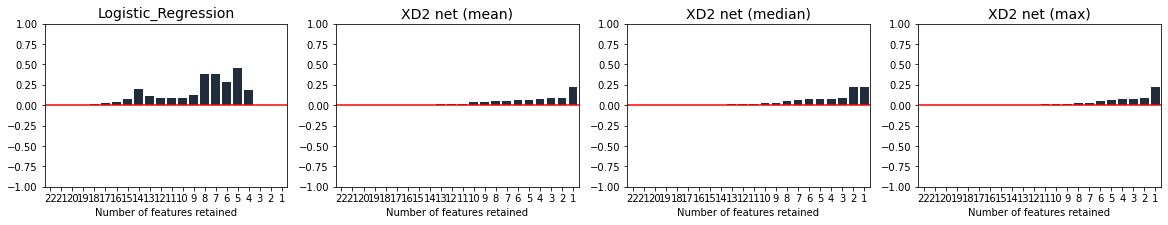

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(20,3))
titles = ['Logistic_Regression','XD2 net (mean)','XD2 net (median)','XD2 net (max)']

features = list(range(1,len(global_case_level)+1))
features_reverse = list(range(1,len(global_case_level)+1))
features_reverse.sort(reverse=True)

for i in range(4): 
  
  sn.barplot(y=tp_arr[i] ,x = features , color = color_a, ax = axes[i])
  axes[i].set_xticklabels(features_reverse)
  axes[i].set_title(titles[i],fontsize=14)
  axes[i].set_xlabel('Number of features retained')
  axes[i].axhline(tp_arr[i][0], color = 'r')
  axes[i].set_ylim([-1, 1])

In [ ]:
for i in range(4):
  print(titles[i])
  print(np.round(tp_arr[i],3))


Logistic_Regression
[0.    0.001 0.006 0.005 0.011 0.026 0.035 0.08  0.2   0.115 0.092 0.09
 0.087 0.129 0.378 0.378 0.289 0.462 0.188   nan   nan   nan]
XD2 net (mean)
[0.    0.    0.001 0.002 0.003 0.004 0.005 0.007 0.008 0.01  0.011 0.02
 0.042 0.044 0.051 0.052 0.065 0.065 0.078 0.09  0.091 0.23 ]
XD2 net (median)
[0.    0.    0.001 0.002 0.003 0.004 0.005 0.007 0.008 0.01  0.011 0.014
 0.022 0.028 0.051 0.063 0.077 0.079 0.078 0.09  0.23  0.23 ]
XD2 net (max)
[0.    0.    0.001 0.001 0.002 0.003 0.004 0.005 0.007 0.008 0.009 0.011
 0.019 0.021 0.024 0.029 0.052 0.065 0.078 0.08  0.091 0.23 ]
